## 寻找道路上的车道线

包括感兴趣区域的选择,灰度,高斯平滑,Canny边缘检测和Hough Transform线检测

In [1]:
# 导入工具库
import matplotlib.pyplot as plt 
import matplotlib.image as mping
import numpy as np
import cv2
%matplotlib inline

Image is: <class 'numpy.ndarray'> with dimension: (540, 960, 3)


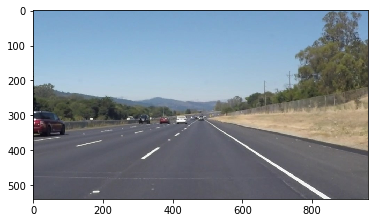

In [2]:
# 读入图像
img = mping.imread('test_images/solidWhiteRight.jpg')

# 输出图像特征,显示图像
print('Image is:', type(img), 'with dimension:',img.shape)
plt.imshow(img)

In [3]:
import math

def grayscale(img):
    """灰度变换"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """边缘检测"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """高斯去燥"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_blur(img, kernel_size):  
    """中值去燥"""
    return cv2.medianBlur(img, kernel_size)
    
def region_of_interest(img, vertices):
    """
    图像蒙版.
    """
    #定义一个蒙版, 所有值都为0
    mask = np.zeros_like(img)   
    
    #根据输入图像的通道数, 设置色彩
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #使用色彩填充vertices构成的多边形 
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #执行蒙版操作
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    画线段
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def get_y_intercept(lane_lines, slopes):
    """
    根据输入的线段和斜率, 计算y方向的截距和平均斜率
    """
    
    slopes = slopes[~np.isnan(slopes)]
    slopes = slopes[~np.isinf(slopes)]
    avg_slope = slopes.mean()
    lane_lines = lane_lines.reshape((lane_lines.shape[0]*2, lane_lines.shape[1]//2))
    x_mean, y_mean = np.mean(lane_lines, axis=0)
    return y_mean - (x_mean*avg_slope), avg_slope

def get_x_intercepts(y_1, y_2, slope, b):
    """
    根据斜率和截距, 计算对应y值的x
    """
    if not (~np.isnan(slope) and ~np.isnan(b)):
        x_1 = x_2 = 0.0
    else:
        x_1 = (y_1 - b)/slope
        x_2 = (y_2 - b)/slope
    return x_1, x_2

prev_left_x1 = 0
prev_left_x2 = 0
prev_right_x1 = 0 
prev_right_x2 = 0 
prev_left_avg_m = 0
prev_right_avg_m = 0
pev_left_avg_m = -1
prev_right_avg_m = 1
prev_left_b = 0
prev_right_b = 0
prev_left_line = 0
prev_right_line = 0

def draw_lines_extrapolated(img, lines, color=[255, 0, 0], thickness=10):
    imgshape = img.shape
    lines = lines.reshape((lines.shape[0], lines.shape[2]))
    y_min = lines.reshape((lines.shape[0]*2, lines.shape[1]//2))[:,1].min()
    
    # slope= (    y2      -     y1   )/(    x2     -     x1    )  
    slopes = (lines[:,3] - lines[:,1])/(lines[:,2] - lines[:,0])
    slopes = slopes[~np.isinf(slopes)]
    slopes = slopes[~np.isnan(slopes)]
    left_lines = lines[slopes < -0.5]   # 左边的行车道斜率为负
    right_lines= lines[slopes > 0.5]    # 右边的行车道斜率为正
    left_slopes = slopes[slopes < -0.5]
    right_slopes= slopes[slopes > 0.5]
    
    global prev_left_avg_m 
    global prev_right_avg_m 
    global prev_left_b
    global prev_right_b
    
    left_b, left_avg_m = get_y_intercept(left_lines, left_slopes)
    right_b, right_avg_m = get_y_intercept(right_lines, right_slopes)

    keep_prev_left = False
    keep_prev_right = False
    
    if left_avg_m < -0.83 or left_avg_m > -0.36:
        left_avg_m = prev_left_avg_m
        left_b = prev_left_b
        keep_prev_left = True
    if right_avg_m > 0.83 or right_avg_m < 0.36:
        right_avg_m = prev_right_avg_m
        right_b = prev_right_b
        keep_prev_right = True
  
    prev_left_avg_m = left_avg_m 
    prev_right_avg_m = right_avg_m
    prev_left_b = left_b
    prev_right_b = right_b
    
    # 根据斜率和截距, 计算对应y值的x
    left_x1, left_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=left_avg_m, b=left_b)
    right_x1, right_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=right_avg_m, b=right_b)
    
    ## 求累积平均值 ##
    global prev_left_x1
    global prev_left_x2
    global prev_right_x1 
    global prev_right_x2 

    if prev_left_x1 != 0 or prev_left_x2 != 0 or prev_right_x1 != 0 or prev_right_x2 !=0:
        alpha = 0.2
        left_x1_new = math.floor((alpha)*left_x1 + (1-alpha)*prev_left_x1)
        left_x2_new = math.floor((alpha)*left_x2 + (1-alpha)*prev_left_x2)
        right_x1_new = math.floor((alpha)*right_x1 + (1-alpha)*prev_right_x1)
        right_x2_new = math.floor((alpha)*right_x2 + (1-alpha)*prev_right_x2)
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new
    else:
        left_x1_new = left_x1
        left_x2_new = left_x2
        right_x1_new = right_x1
        right_x2_new = right_x2
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new

    left_line = np.array([left_x1_new, y_min, left_x2_new, imgshape[0]], dtype=np.int32)
    right_line = np.array([right_x1_new, y_min, right_x2_new, imgshape[0]], dtype=np.int32)
    
    if keep_prev_left:
        left_line = prev_left_line
        left_x1_new = prev_left_x1
        left_x2_new = prev_left_x2
    if keep_prev_right:
        right_line = prev_right_line
        right_x1_new = prev_right_x1
        right_x2_new = prev_right_x2
        
    cv2.line(img, (int(left_x1_new), int(y_min)), (int(left_x2_new), imgshape[0]), color, thickness)
    cv2.line(img, (int(right_x1_new), int(y_min)), (int(right_x2_new), imgshape[0]), color, thickness)        
        
    ## 求累积平均值结束 ##
   
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate=False):
    """
    `img` Canny边缘检测的输出.
    `rho` = Hough Grid中像素的距离
    `theta` = Hough grid中角度的距离
    `threshold` = 最小的voting数值
    `min_line_len` = 构成一条线的最小像素个数
    `max_line_gap` = 可以相连的线段之间的最大距离
    返回黑背景上面有白线的图.
    """ 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if not extrapolate:
        draw_lines(line_img, lines)
    elif extrapolate:
        draw_lines_extrapolated(line_img, lines)
    
    return line_img


def weighted_img(img, initial_img, a=0.8, b=1.):
    """
    `img` hough_lines()的输出, 黑背景上面有白线的图.
    
    `initial_img` 原始图像.
    
    加权相加:
    
    initial_img * a + img * b 
    """
    return cv2.addWeighted(initial_img, a, img, b, 0)


### 在图像上面测试

In [4]:
import os
os.listdir('test_images/')

['challenge-area-1.png',
 'solidYellowCurve.jpg',
 'challenge-area.png',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

solidYellowCurve.jpg

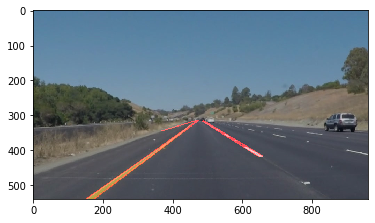

In [10]:
img = mping.imread('test_images/solidYellowCurve.jpg')
s = img.shape
img_gray = grayscale(img) # 灰度
img_blur = gaussian_blur(img_gray, kernel_size=5)
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)
veritices = np.array([[(0, s[0]), (425, 315), (540, 315),(s[1], s[0])]], dtype=np.int32)

masked_edges = region_of_interest(img_edge, veritices)
img_hough_lines = hough_lines(masked_edges, rho=1, theta = np.pi/180, threshold=40,min_line_len=12, max_line_gap=40)

img_lanes = weighted_img(img=img_hough_lines, initial_img = img, a=0.8, b=1)
plt.imshow(img_lanes)

Extrapolated lines

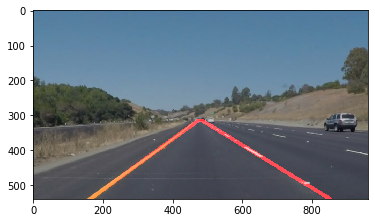

In [11]:
extrapolated = hough_lines(masked_edges, rho=1, theta = np.pi/180, threshold=40,min_line_len=12, max_line_gap=30, extrapolate=True)
img_lanes_ext = weighted_img(img=extrapolated, initial_img=img, a=0.8,b=1)
plt.imshow(img_lanes_ext)

### Test on Viideos

You know what's cooler than drawing lanes over images? Drawing lanes over vide0!

We can test our solution on two provided vides:

solidWitedRight.mp4

solidYellowLeft.mp4

In [18]:
# Import everyting needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

def process_iamge(image):
    s = image.shape
    img_gray = grayscale(image)
    img_blur = gaussian_blur(img_gray, kernel_size=5)
    img_edge = canny(img_gray, low_threshold=50, high_threshold=100)
    vertices = np.array([[(s[1]*0.2, s[0]), (s[1]*0.4, s[0]*0.6), (s[1]*0.55, s[0]*0.6) ,(s[1], s[0])]], dtype=np.int32)
    
    masked_edge = region_of_interest(img_edge, veritices)
    extra  = hough_lines(masked_edges, rho=1, theta = np.pi/180, threshold=40,min_line_len=12, max_line_gap=70)

    img_lanes_ext  = weighted_img(img=extra, initial_img = image, a=0.8, b=1)
    return img_lanes_ext

### 测试视频上的测试效果

In [19]:
v1_out = 'white.mp4'
clip1 = VideoFileClip('solidWhiteRight.mp4')
v1_clip = clip1.fl_image(process_iamge)
%time v1_clip.write_videofile(v1_out, audio=False)

t:   8%|▊         | 17/221 [00:00<00:01, 163.89it/s, now=None]

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
CPU times: user 1.77 s, sys: 322 ms, total: 2.09 s
Wall time: 2.32 s


### 测试弯道上面的